# Animate Search Sequences
This notebook gives an example of how to visualize search sequences from our [Action Search paper](http://humamalwassel.com/publication/action-search/).

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import shutil

# Global config
params = {
   'font.family': 'serif','font.serif': 'Times',
   'text.usetex': True,
   'xtick.major.size': 8,
   'ytick.major.size': 8,
   'xtick.major.width': 3,
   'ytick.major.width': 3,
   }
matplotlib.rcParams.update(params)

%matplotlib inline

## Helper Funcitons

In [2]:
def read_frame(frame_num, frames_folder, frame_extension):
    return plt.imread(os.path.join(frames_folder,'{:06d}.{}'.format(int(frame_num), frame_extension)))

def animate_search_step(frame_images, search_sequence, frames_idxs, search_step_num,
                        figsize=(35,5), fontsize=38, height_ratios=[1,1], frame_link_point=[0.5,0.05],
                        xlabel='Search Step', ylabel='Video Time', step_color='#1f78b4',
                        delta=0.5, lw=5, circle_size=300, draw_current_frame=False):

    gs = gridspec.GridSpec(2, len(frames_idxs), height_ratios=height_ratios)
    gs.update(wspace=0.025)
    fig = plt.figure(figsize=figsize)
    transFigure = fig.transFigure.inverted()
    
    # draw frames
    frames_axes = [None]*(len(frames_idxs))
    for i,j in enumerate(frames_idxs):
        if j > search_step_num + (0 if draw_current_frame else -1):
            continue
        frames_axes[i] = plt.subplot(gs[:1,i])
        plt.axis('off')
        plt.imshow(frame_images[i])
        plt.title('t={:.1f} sec'.format(search_sequence[j]),fontsize=fontsize/1.1)

    # add placeholder white frame if no frames are shown (i.e. in the first couple of steps)
    if frames_axes[0] is None:
        frames_axes[0] = plt.subplot(gs[:1,0])
        plt.axis('off')
        plt.title('t={:.1f} sec'.format(search_sequence[0]),fontsize=fontsize/1.1,color='w')

    
    # draw search steps and arrows connecting them 
    ax = plt.subplot(gs[1:,:])
    plt.scatter(range(search_step_num+1), search_sequence[:search_step_num+1], color=step_color, s=circle_size)
    for i in range(search_step_num):
        ax.annotate("", xy=(i+1, search_sequence[i+1]), xycoords='data',
                    xytext=(i, search_sequence[i]), textcoords='data',
                    arrowprops=dict(arrowstyle="-|>, head_width=0.4, head_length=1",
                                    lw=4, connectionstyle="arc3", color=step_color
                                   ),
                   )

    # set plot limits
    x_lim = [-delta,len(search_sequence)-1+delta]
    y_lim = [np.min(search_sequence)-delta-10,(np.max(search_sequence)*1.05 +delta)* 1.1]
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
        
    # draw dash lines connecting frames to search steps
    for i,j in enumerate(frames_idxs):
        if j > search_step_num + (0 if draw_current_frame else -1):
            continue
        coord1 = transFigure.transform(frames_axes[i].transAxes.transform(frame_link_point))
        coord2 = transFigure.transform(ax.transData.transform([j,search_sequence[j]]))

        line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]), 
                                       linestyle='--',  dashes=(1, 1), lw=lw,
                                       transform=fig.transFigure,color=step_color)
        fig.lines.append(line)


    
    # remove axes ticks 
    plt.xticks(np.arange(0, len(search_sequence), 1.0))
    ax.set_xticklabels(['']*len(search_sequence))
    ax.set_yticklabels(['']*len(search_sequence))
    ax.tick_params(axis='y', which='both', bottom='off', top='off', left='off', labelbottom='off') 
    
def create_animation(output_folder, output_extension,
                     frame_images, search_sequence, frames_idxs,
                     figsize=(35,5), fontsize=38, height_ratios=[1,1], frame_link_point=[0.5,0.05],
                     xlabel='Search Step', ylabel='Video Time', step_color='#1f78b4',
                     delta=0.5, lw=5, circle_size=300):

    animation_frame_dir = os.path.join(output_folder, 'animation_frames')
    gif_filename = os.path.join(output_folder,'{}_animation.gif'.format(output_folder))
    final_frame_filename = os.path.join(output_folder,'{}.{}'.format(output_folder,output_extension))

    if os.path.exists(animation_frame_dir):
        shutil.rmtree(animation_frame_dir)
    os.makedirs(animation_frame_dir)

    animation_frame_number = 0
    for i in (range(0,len(search_sequence)-1)):
        for draw_current_frame in [False, True]:
            plt.close()
            animate_search_step(search_step_num=i,
                                frame_images=frame_images, 
                                search_sequence=search_sequence,
                                figsize=figsize,
                                frames_idxs=frames_idxs,
                                fontsize=fontsize,
                                height_ratios=height_ratios,
                                frame_link_point=frame_link_point,
                                xlabel=xlabel,
                                ylabel=ylabel,
                                delta=delta,
                                lw=lw,
                                circle_size=circle_size,
                                step_color=step_color,
                                draw_current_frame=draw_current_frame
                                )
            plt.savefig(os.path.join(animation_frame_dir,'{:06d}.{}'.format(animation_frame_number, output_extension)), bbox_inches='tight')
            animation_frame_number+=1;

    for i in [len(search_sequence)-2]*9:
        plt.close()
        animate_search_step(search_step_num=i,
                            frame_images=frame_images, 
                            search_sequence=search_sequence,
                            figsize=figsize,
                            frames_idxs=frames_idxs,
                            fontsize=fontsize,
                            height_ratios=height_ratios,
                            frame_link_point=frame_link_point,
                            xlabel=xlabel,
                            ylabel=ylabel,
                            delta=delta,
                            lw=lw,
                            circle_size=circle_size,
                            step_color=step_color,
                            draw_current_frame=draw_current_frame
                            )
        plt.savefig(os.path.join(animation_frame_dir,'{:06d}.{}'.format(animation_frame_number, output_extension)), bbox_inches='tight')
        animation_frame_number+=1;

    # save the last animation frame seprately for the pdf latex verison 
    plt.savefig(final_frame_filename, bbox_inches='tight')

    try:
        cmd = 'convert -delay 15 '
        cmd += '-loop 0 {}/*{} {}'.format(animation_frame_dir, output_extension, gif_filename)
        os.system(cmd)
    except Exception as e:
        print('Animation failed for video: {}'.format(video_id))
        print(e)

## Plot a Search Sequence 

Specify the following variables: 
- `search_sequence_filename`: the path to the CSV filename containing a search sequence under a column named `time`.
- `frames_folder`: the path to the pre-extracted frames folder. Each frame filename should be of the format `'{:06d}.{}'.format(int(frame_num), frame_extension)`. <span style="color:red">Uncompress the `example/frames.tar.gz` file first before running this example.</span>
- `frame_extension`: the file extension of the frames.
- `fps`: the frame rate at which the frames were extracted.
- `output_folder`: the path to the output folder at which the animation GIF is saved.
- `output_extension`: the extension of the intermediate animation figures (e.g. pdf)

**<span style="color:blue">NOTE</span>: This plot function is optimized to show exactly 30 search steps. Adjust the above code accordingly if you wish to show a different number of steps.**

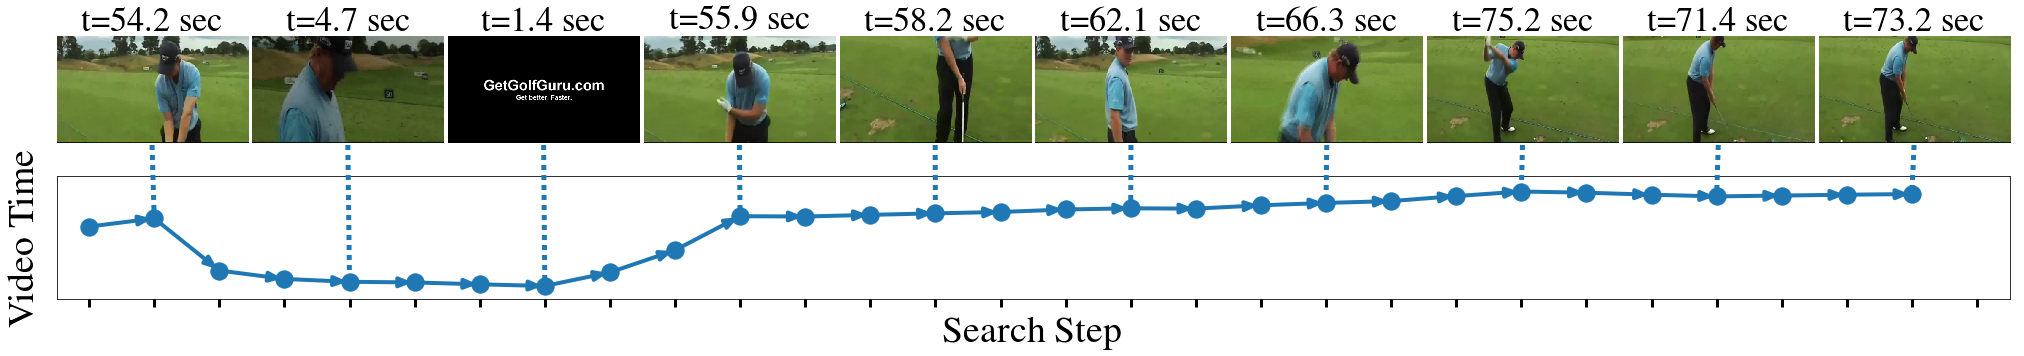

In [3]:
search_sequence_filename = 'example/search_sequence.csv'
frames_folder = 'example/frames/' 
frame_extension = 'png'
fps = 5
output_folder = 'example_output'
output_extension = 'pdf'

search_sequence = pd.read_csv(search_sequence_filename).loc[:]['time'].values 
frames_idxs = np.arange(1,len(search_sequence),3)
frame_images = [None]*len(frames_idxs)
for i,j in enumerate(frames_idxs):
    frame_images[i] = read_frame(np.round(search_sequence[j]*fps+1).astype(int), frames_folder, frame_extension=frame_extension)

create_animation(output_folder=output_folder,output_extension=output_extension,
               frame_images=frame_images,
               search_sequence=search_sequence,
               frames_idxs=frames_idxs)